In [1]:
import os
import time
import random
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [2]:
# Set random seed for reproducibility
random.seed(42)

In [3]:
def walk_through_dir(dir_path):
  """Walks through the directory and returns it's content"""
  for dir_path, dirname, filenames in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dir_path}")

walk_through_dir("D:\\Ashutosh\\Herbs\\Cleanede_Data")

There are 2 directories and 0 images in D:\Ashutosh\Herbs\Cleanede_Data
There are 109 directories and 0 images in D:\Ashutosh\Herbs\Cleanede_Data\Train
There are 0 directories and 544 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Achillea Millefolium
There are 0 directories and 563 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Achyranthes Aspera
There are 0 directories and 567 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Acorus calamus
There are 0 directories and 563 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Aegle marmelos
There are 0 directories and 554 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Aerva lanata
There are 0 directories and 553 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Agave americana
There are 0 directories and 552 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Ageratina adenophora
There are 0 directories and 553 images in D:\Ashutosh\Herbs\Cleanede_Data\Train\Allium sativum
There are 0 directories and 541 images in D:\Ashutosh\Herbs\Cleanede_Data

In [4]:
IMAGE_PATH = "D:\\Ashutosh\\Herbs\\Cleanede_Data"

# Get all image paths
image_path_list = list(Path(IMAGE_PATH).glob("**/*/*"))
rand_image = random.choice(image_path_list)
image_class = rand_image.parent.stem

# Open and display a random image
img = Image.open(rand_image)
print(f"The image path is {rand_image} and the width and height are {img.width} {img.height}")
img.show()  # Uncomment if you want to display the image

The image path is D:\Ashutosh\Herbs\Cleanede_Data\Train\Calendula officinalis\image_774.jpg and the width and height are 256 256


In [5]:
def apply_random_augmentation(image):
    # Convert PIL image to TensorFlow tensor
    image = tf.convert_to_tensor(np.array(image), dtype=tf.float32)
    
    # Normalize image values to [0, 1] if needed
    if tf.reduce_max(image) > 1.0:
        image = image / 255.0

    # Randomly apply a combination of augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Clip the values to be in the range [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    # Convert TensorFlow tensor back to a numpy array
    image = image.numpy()
    
    # Convert back to an 8-bit format if needed
    if np.max(image) > 1.0:
        image = (image * 255).astype(np.uint8)

    return image

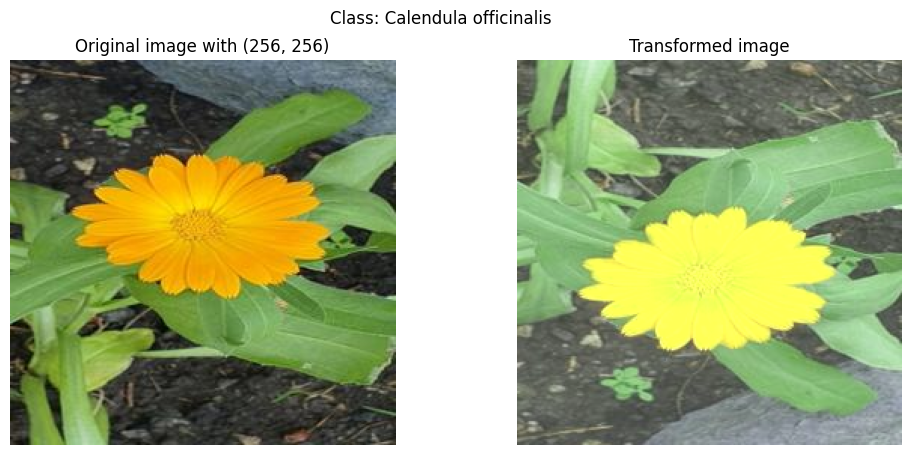

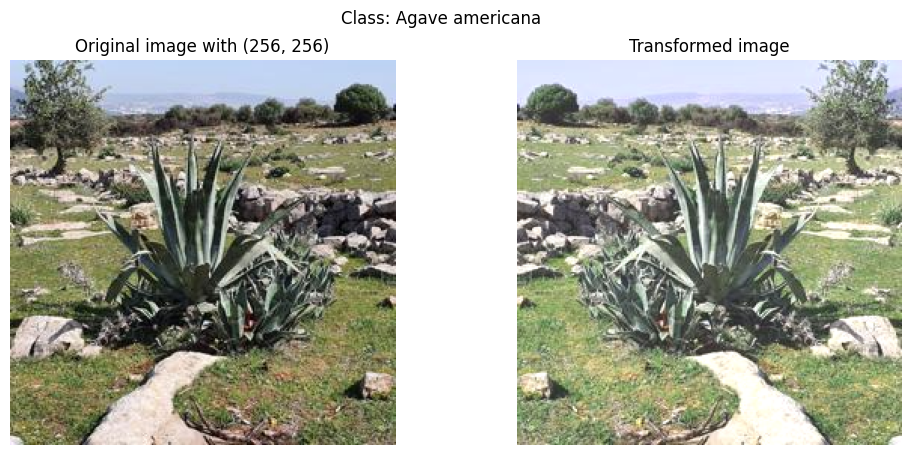

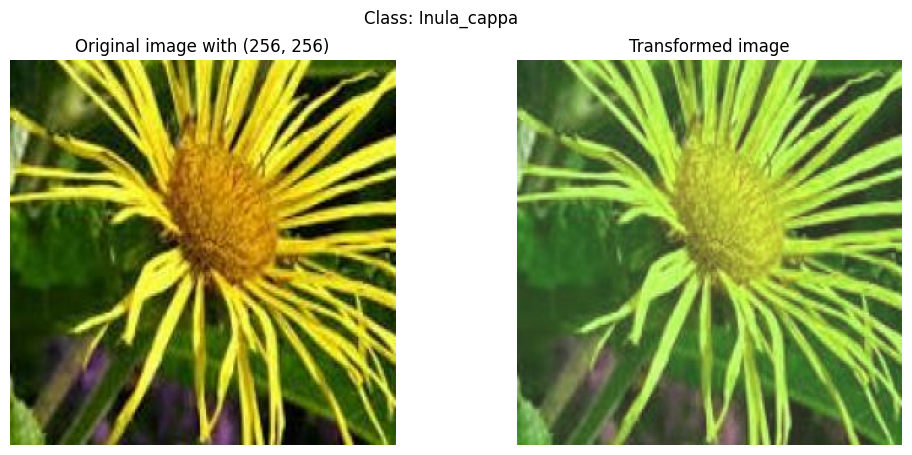

In [6]:
# let's try to plot the original and transformed images
def plot_transformed_image(img_paths, transform, n=9, seed=42):
    """Selects random images and plots the original and transformed images."""
    
    random.seed(seed)
    random_image_paths = random.sample(img_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
            
            # Plot the original image
            ax[0].imshow(f)
            ax[0].set_title(f"Original image with {f.size}")
            ax[0].axis('off')

            # Plot the transformed image
            transformed_image = transform(f)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image")
            ax[1].axis('off')

            fig.suptitle(f"Class: {image_path.parent.stem}")
            plt.show()


plot_transformed_image(img_paths=image_path_list, transform=apply_random_augmentation, n=3, seed=42)

In [ ]:
def create_folder(fd):
    if not os.path.exists(fd):
        os.makedirs(fd)

output = 'D:\\Ashutosh\\Herbs\\Output\\ResNet50'  
create_folder(output)

In [8]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [9]:
# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Set image size and batch size
image_size = (224, 224)
batch_size = 32

In [11]:
train_directory = 'D:\\Ashutosh\\Herbs\\Cleanede_Data\\Train'
validation_directory = 'D:\\Ashutosh\\Herbs\\Cleanede_Data\\Val'

In [12]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 60236 images belonging to 109 classes.
Found 15059 images belonging to 109 classes.


In [13]:
# Create DenseNet121 model
base_model = ResNet50(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'
)

model_resnet = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(109, activation='softmax')  # Verify this matches your number of classes
])

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 109)               55917     
                                                                 
Total params: 24,692,717
Trainable params: 24,639,597
Non-trainable params: 53,120
_______________________________________

In [14]:
# Define callbacks
filepath = os.path.join(output, "HerbClassification_BEST.h5")
csv_logger = CSVLogger(os.path.join(output, f"CSV_Logger-MC_ML-{time.time()}.csv"))
early_stop = EarlyStopping(patience=15, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

callbacks_list = [checkpoint, reduce_lr, early_stop, csv_logger]

In [15]:
# Compile model
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

In [16]:
# Train model
epochs = 200
resnet_history = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/200
1882/1882 [==============================] - ETA: 0s - loss: 4.2860 - accuracy: 0.0602
Epoch 1: val_accuracy improved from -inf to 0.12354, saving model to D:\Ashutosh\Herbs\Output\ResNet50-\HerbClassification_BEST.h5
1882/1882 [==============================] - 1874s 993ms/step - loss: 4.2860 - accuracy: 0.0602 - val_loss: 4.5101 - val_accuracy: 0.1235 - lr: 0.0010
Epoch 2/200
1882/1882 [==============================] - ETA: 0s - loss: 3.4919 - accuracy: 0.1926
Epoch 2: val_accuracy improved from 0.12354 to 0.22507, saving model to D:\Ashutosh\Herbs\Output\ResNet50-\HerbClassification_BEST.h5
1882/1882 [==============================] - 395s 210ms/step - loss: 3.4919 - accuracy: 0.1926 - val_loss: 3.6899 - val_accuracy: 0.2251 - lr: 0.0010
Epoch 3/200
1882/1882 [==============================] - ETA: 0s - loss: 2.8814 - accuracy: 0.3149
Epoch 3: val_accuracy improved from 0.22507 to 0.26709, saving model to D:\Ashutosh\Herbs\Output\ResNet50-\HerbClassification_BEST.h5
188

In [17]:
# Save final weights
model_resnet.save_weights(os.path.join(output, 'herbs_100Epoch_Last_WT.h5'))

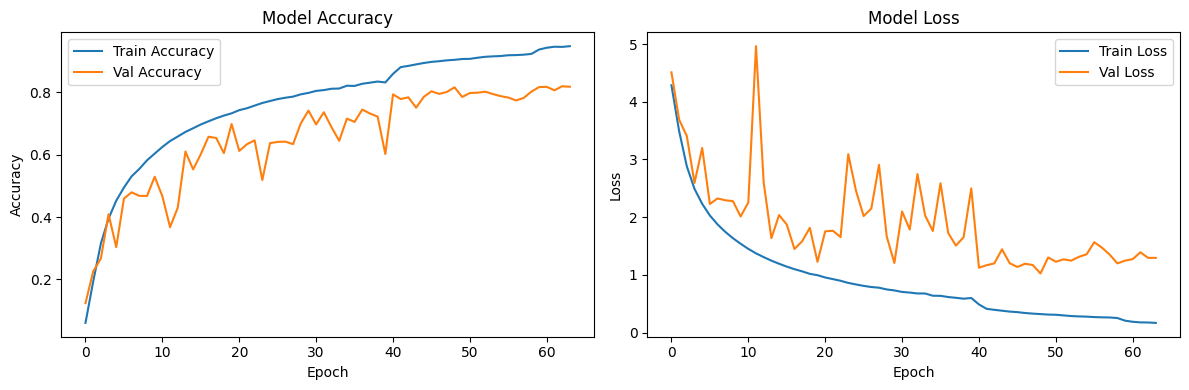

In [18]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.tight_layout()
    plt.show()

plot_history(resnet_history)

In [19]:
import numpy as np
# Reset the generator to start from the beginning
validation_generator.reset()

# Create empty lists to store predicted labels and true labels
resnet_predicted_labels = []
resnet_true_labels = []

# Iterate over the validation data generator and make predictions
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model_resnet.predict(images)

    # Convert predictions and labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert class indices to class labels
    resnet_predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)

    # Get the true labels from the validation generator
    resnet_true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


# Flatten the nested list to a single-dimensional array
resnet_true_labels = [label[0] for label in resnet_true_labels]

resnet_true_label= [validation_generator.class_indices[label] for label in resnet_true_labels]
resnet_predicted_label = [validation_generator.class_indices[label] for label in resnet_predicted_labels]
# Print the converted true labels
# Print the predicted labels and true labels
print("Predicted Labels:", resnet_predicted_label)
print("True Labels:", resnet_true_label)


1/1 [==============================] - 1s 559ms/step
Predicted Labels: [65, 99, 15, 17, 64, 108, 84, 89, 100, 18, 88, 104, 74, 50, 53, 90, 25, 95, 7, 15, 72, 88, 47, 55, 82, 24, 107, 3, 80, 77, 58, 12, 51, 79, 89, 48, 21, 25, 33, 95, 76, 17, 105, 26, 80, 21, 22, 108, 41, 0, 77, 37, 90, 36, 77, 40, 3, 3, 52, 66, 50, 82, 105, 91, 36, 46, 71, 77, 51, 32, 10, 78, 97, 2, 42, 67, 105, 6, 104, 12, 22, 13, 79, 19, 63, 76, 67, 90, 89, 81, 78, 100, 89, 66, 90, 106, 108, 91, 60, 57, 13, 67, 65, 47, 71, 30, 73, 91, 49, 37, 79, 106, 63, 84, 61, 93, 78, 23, 88, 85, 50, 63, 79, 84, 15, 16, 64, 70, 25, 91, 79, 37, 104, 106, 92, 42, 44, 70, 72, 64, 108, 24, 105, 55, 99, 52, 19, 76, 101, 6, 91, 21, 62, 2, 43, 10, 99, 71, 19, 105, 95, 20, 48, 66, 56, 29, 75, 13, 17, 104, 104, 91, 93, 50, 18, 57, 79, 9, 90, 9, 45, 56, 34, 23, 9, 62, 70, 41, 2, 107, 20, 7, 104, 20, 8, 105, 21, 63, 53, 39, 42, 57, 99, 102, 7, 99, 89, 76, 66, 27, 38, 31, 18, 1, 47, 47, 98, 54, 39, 20, 49, 82, 42, 36, 91, 22, 94, 90, 53, 69, 

## Calculating AUC score

In [22]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(resnet_true_label)  # Replace with your true labels
predicted_labels = np.array(resnet_predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(109):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)


AUC Scores for each class:
[0.8870153058152118, 0.7936769987389413, 0.9462629674816816, 0.7226920619826503, 0.9175735246162905, 0.9582783623105894, 0.8847662799275702, 0.8267941498029993, 0.8984985859609135, 0.9492243375262316, 0.9213766864613013, 0.873799110845372, 0.7949703863444804, 0.9107437547703034, 0.8297623295465504, 0.9118870357954334, 0.8564985581114614, 0.8430221522520712, 0.931752682988517, 0.9296129423478195, 0.8530207386666012, 0.9832329250061361, 0.8887592255495252, 0.8916043632166614, 0.8318250882602672, 0.9790756660023213, 0.9246361159028976, 0.8014761492464879, 0.9265063854373632, 0.9448771641216261, 0.892019285091877, 0.9882716241686007, 0.9534314774193486, 0.8586129585963889, 0.864075147449081, 0.8382892918291148, 0.7344786564099253, 0.9388189972001076, 0.9527901262474047, 0.9780351746355992, 0.9262306883985065, 0.9168725982992144, 0.9784552717978853, 0.9878027695135437, 0.9719444354529185, 0.9509766507266468, 0.9684961595908497, 0.966788127617044, 0.893786631118310

## Calculating F1 score

In [23]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(resnet_true_label)  # Replace with your true labels
predicted_labels = np.array(resnet_predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(109):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)


F1 Scores for each class:
[0.8039867109634552, 0.5869565217391305, 0.8350877192982457, 0.40522875816993464, 0.8872727272727273, 0.8737864077669902, 0.8351648351648352, 0.6416382252559727, 0.8141025641025641, 0.85, 0.8184438040345822, 0.8253968253968254, 0.5907172995780591, 0.7468354430379747, 0.6917293233082706, 0.7880794701986755, 0.7019867549668874, 0.6666666666666666, 0.8442906574394463, 0.8136645962732919, 0.7759197324414716, 0.9707112970711297, 0.7734375, 0.8063241106719368, 0.6714285714285714, 0.9553264604810997, 0.8444444444444444, 0.6417910447761194, 0.7861635220125787, 0.8941176470588236, 0.8, 0.9767441860465116, 0.9045936395759717, 0.662613981762918, 0.7383512544802867, 0.7293233082706767, 0.45774647887323944, 0.8588235294117647, 0.9133858267716536, 0.9703703703703703, 0.8797250859106529, 0.8736462093862816, 0.9507042253521126, 0.9264705882352942, 0.9256756756756757, 0.7289719626168224, 0.9220338983050848, 0.9052631578947369, 0.7580645161290323, 0.8169014084507042, 0.67469879

## Confusion Matrix

15059


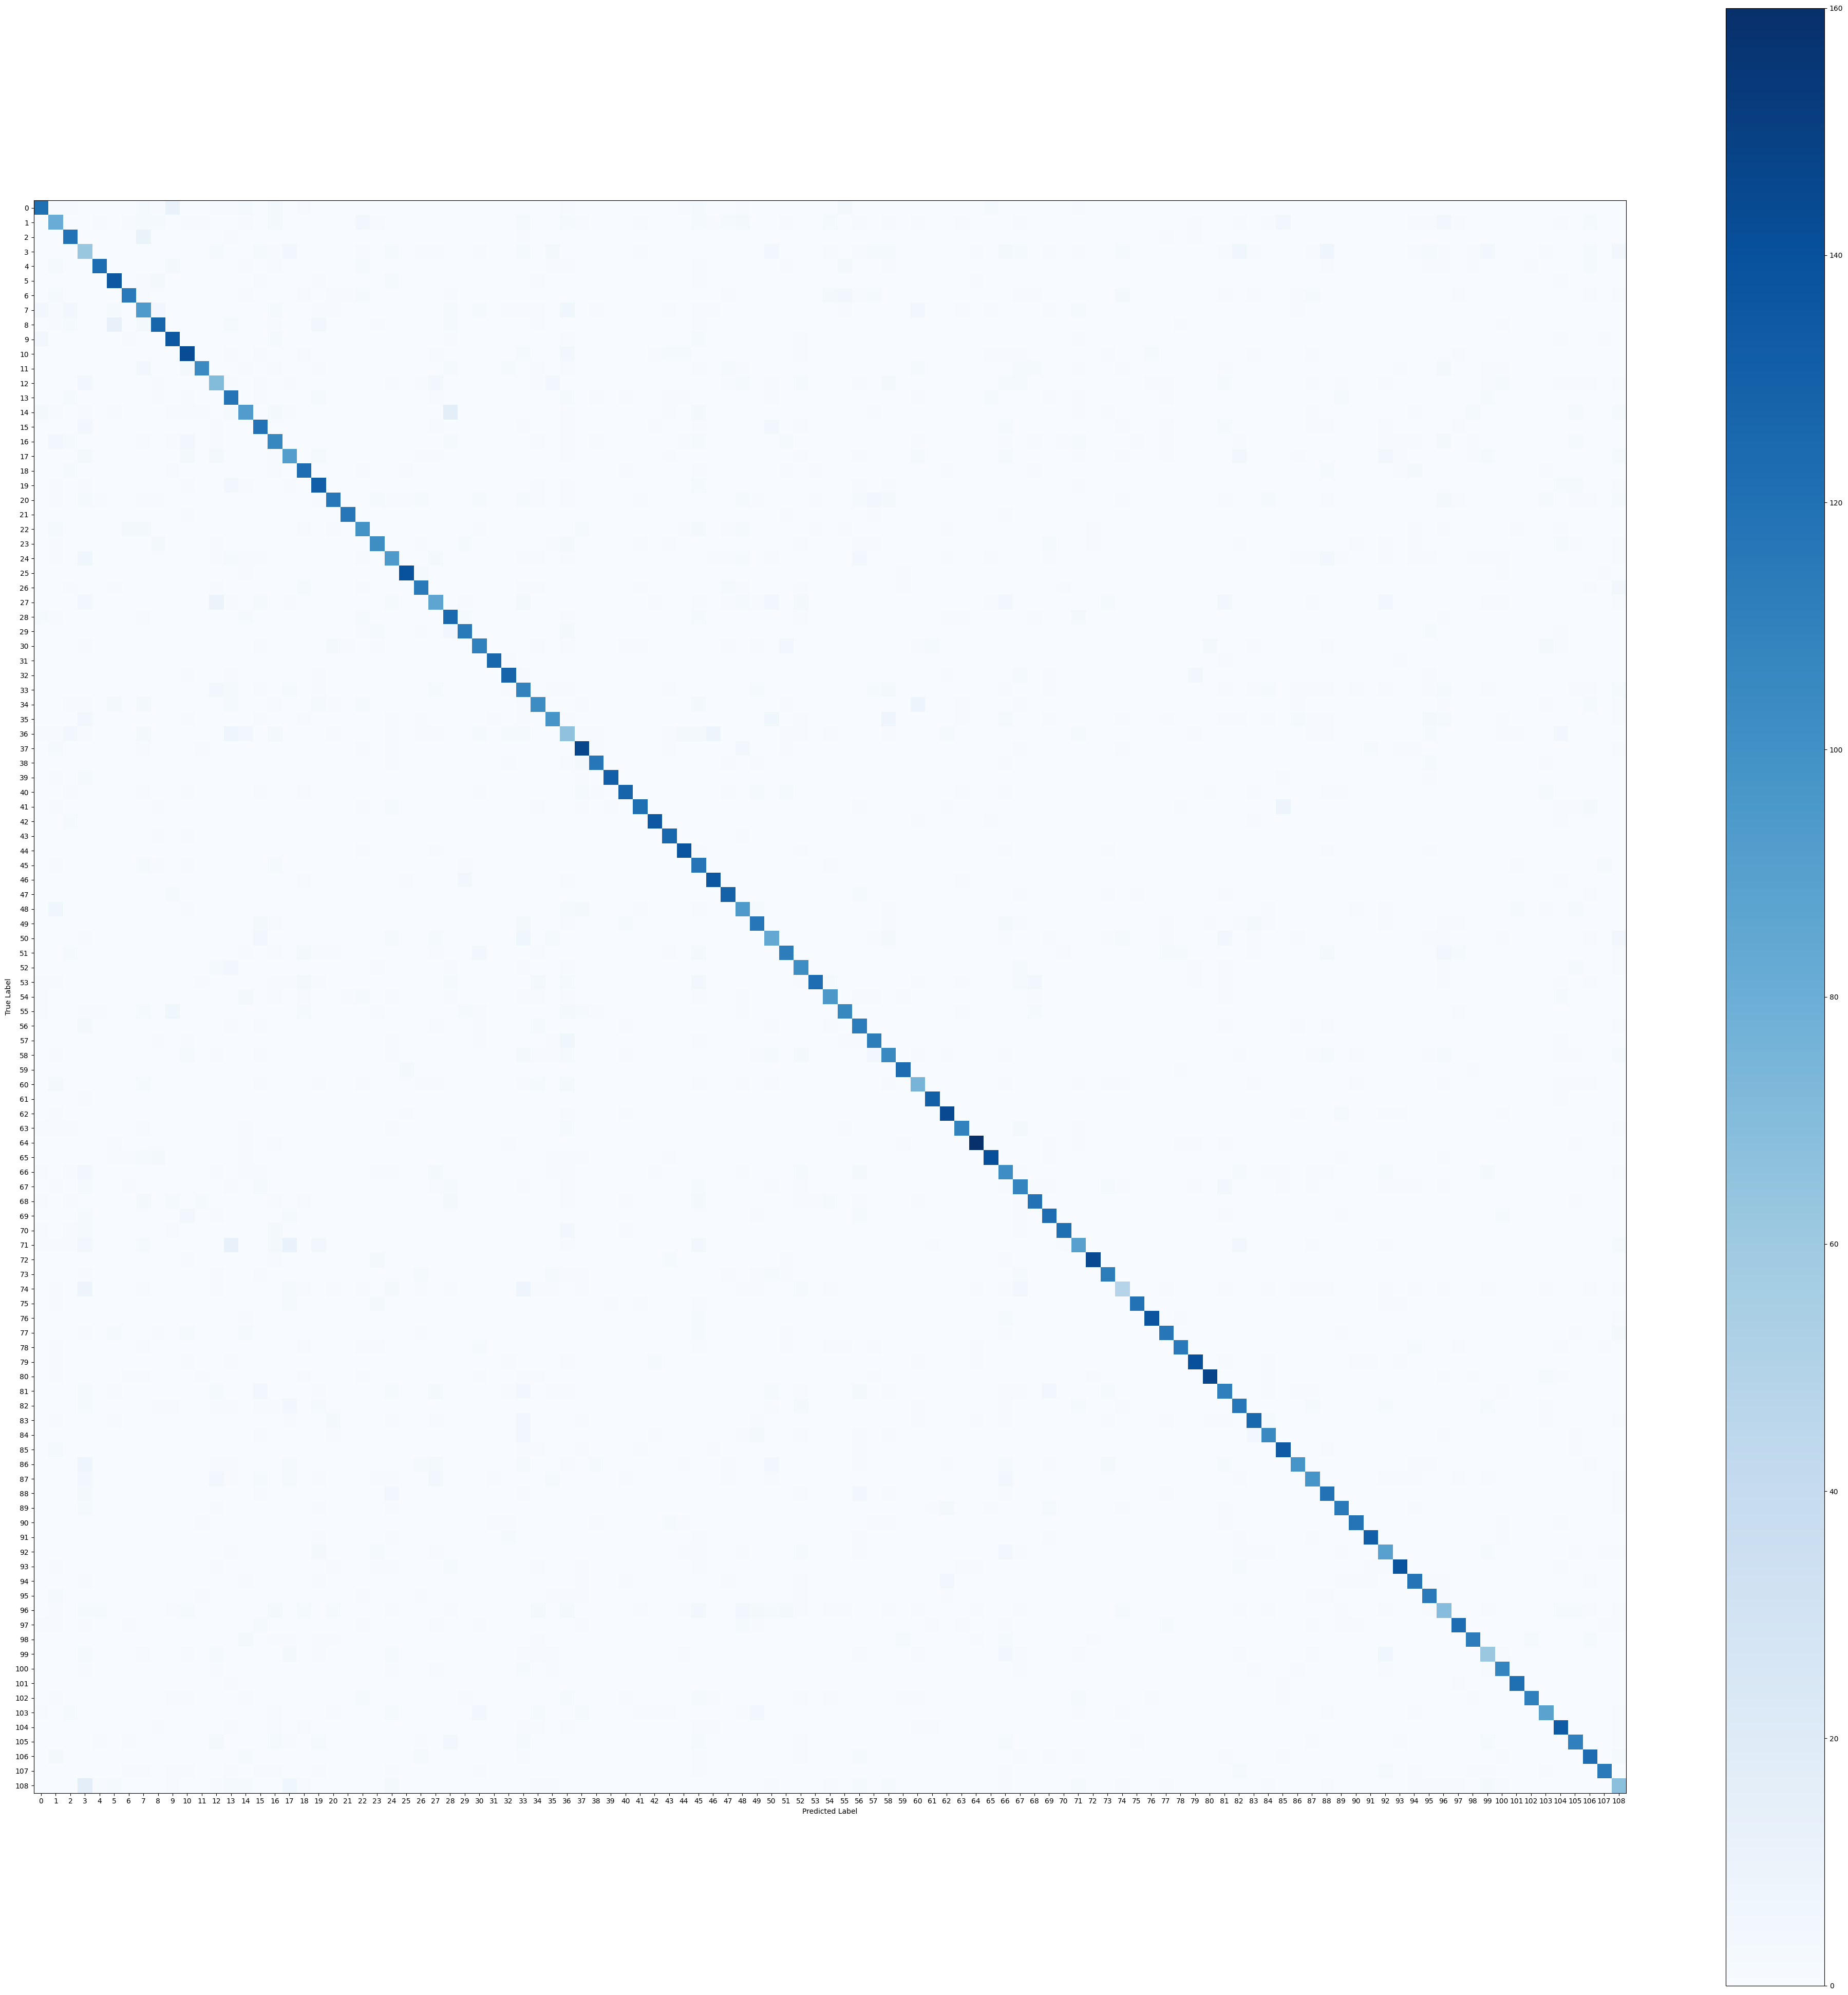

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

print(len(true_labels))

y_true = np.array(resnet_true_label)
y_pred = np.array(resnet_predicted_label)

y_true, y_pred
# convert numpy arrays to PyTorch tensors
y_true_t = tf.cast(y_true, dtype='float32')
y_pred_t = tf.cast(y_pred, dtype='float32')


# compute confusion matrix
cm = confusion_matrix(y_true_t, y_pred)

# plot confusion matrix
plt.figure(figsize=(50,50))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(109))
plt.yticks(np.arange(109))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


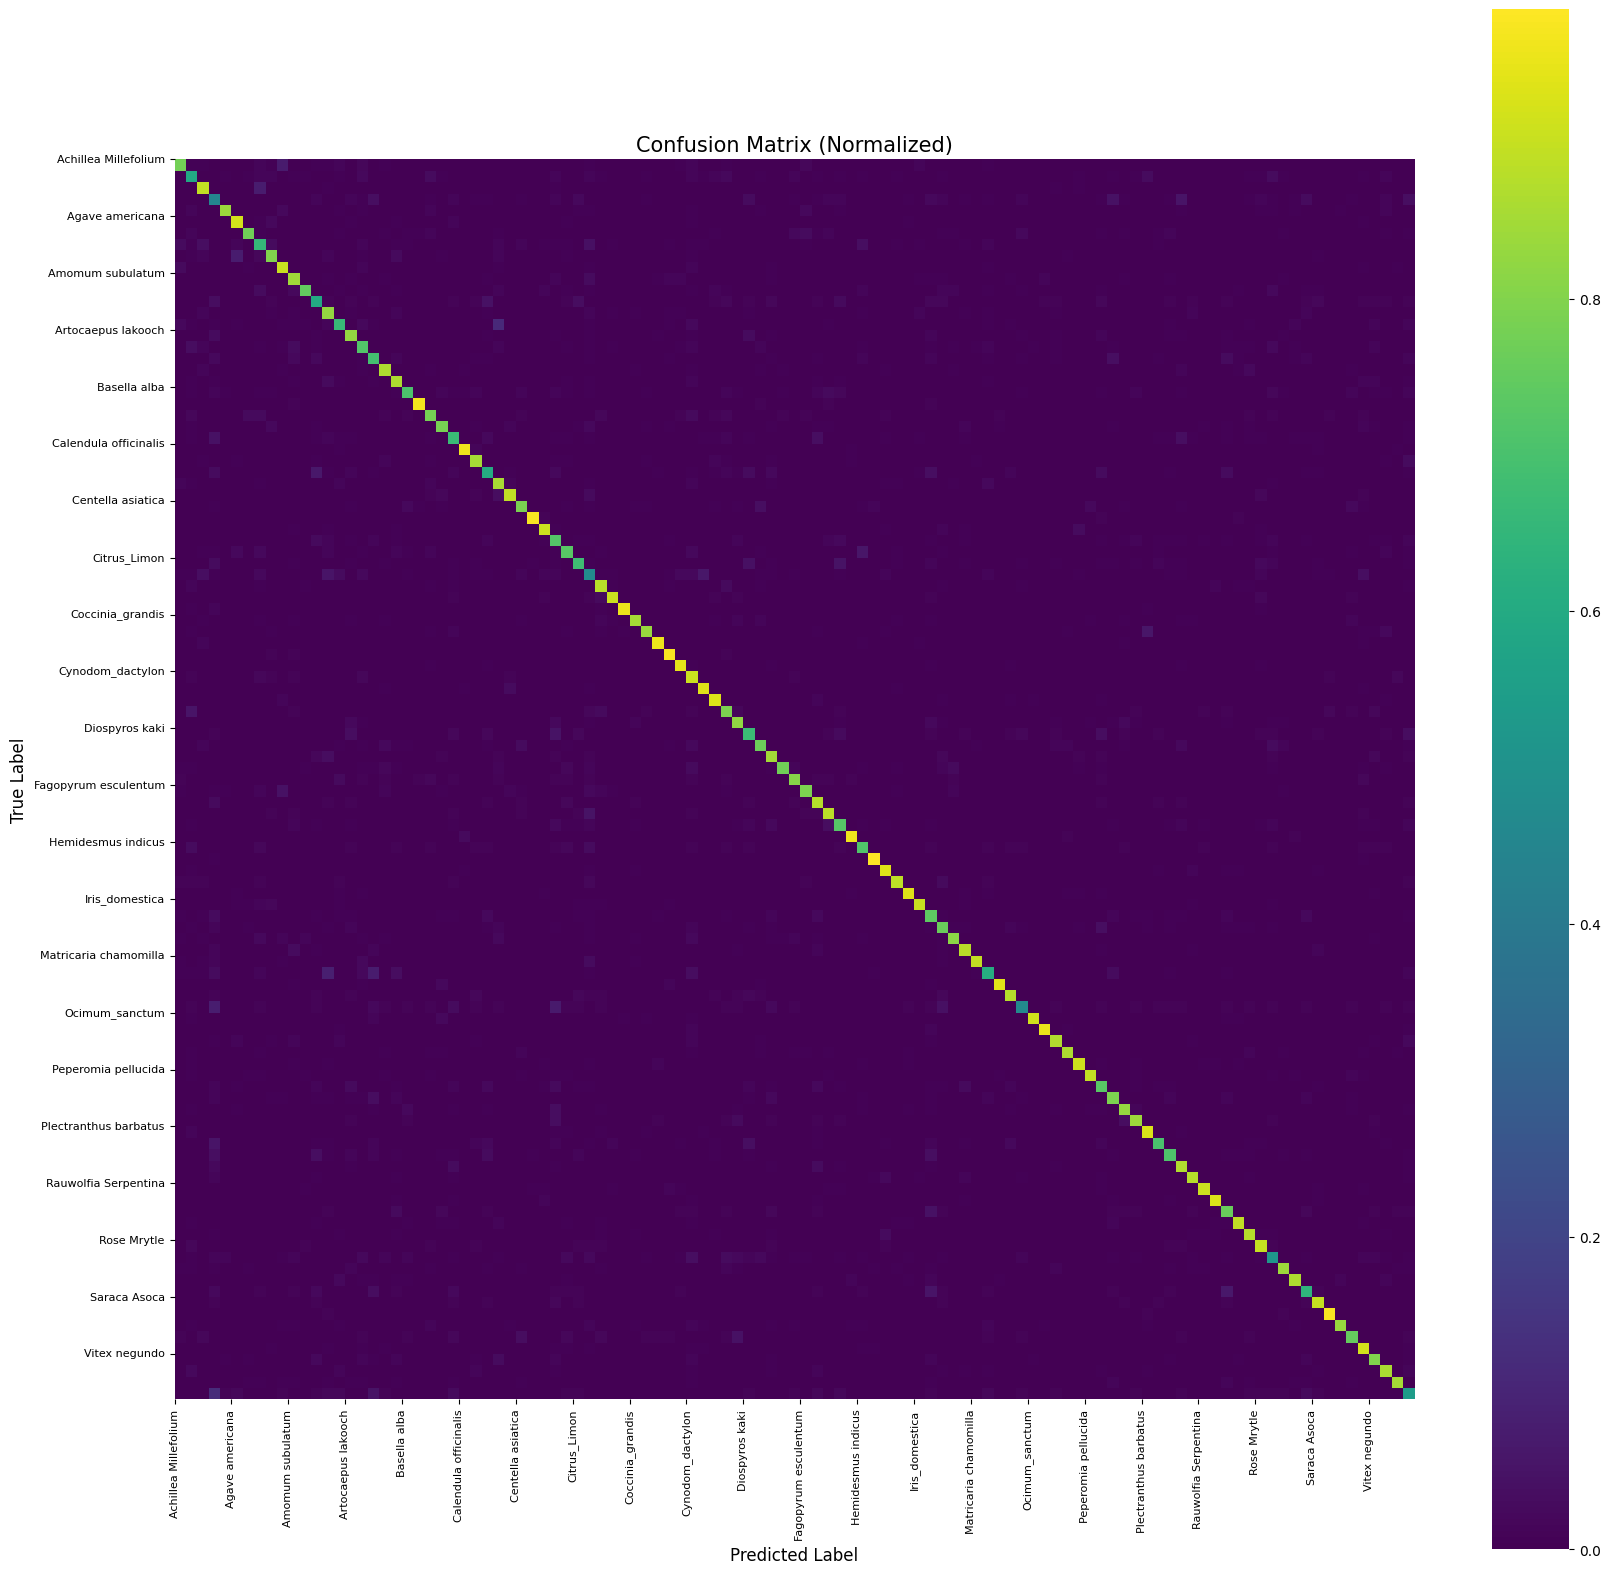

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(resnet_true_label, resnet_predicted_label)

# Normalize the confusion matrix (percentage form)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set figure size
plt.figure(figsize=(20, 20))

# Plot heatmap
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap="viridis", square=True)

# Show only some labels (not all 109)
skip_labels = 5  # Adjust this value to reduce clutter
ticks = np.arange(0, 109, skip_labels)
tick_labels = [list(validation_generator.class_indices.keys())[i] for i in ticks]

plt.xticks(ticks, tick_labels, rotation=90, fontsize=8)
plt.yticks(ticks, tick_labels, fontsize=8)

# Labels
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix (Normalized)", fontsize=15)

# Show plot
plt.show()

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

                           precision    recall  f1-score   support

     Achillea Millefolium       0.83      0.78      0.80       156
       Achyranthes Aspera       0.58      0.59      0.59       137
           Acorus calamus       0.78      0.89      0.84       133
           Aegle marmelos       0.37      0.45      0.41       137
             Aerva lanata       0.95      0.84      0.89       146
          Agave americana       0.83      0.92      0.87       147
     Ageratina adenophora       0.91      0.77      0.84       148
           Allium sativum       0.63      0.66      0.64       143
                Aloe Vera       0.83      0.80      0.81       159
               Ammi majus       0.80      0.90      0.85       151
         Amomum subulatum       0.79      0.85      0.82       168
  Andrographis paniculata       0.92      0.75      0.83       139
          Annona squamosa       0.59      0.59      0.59       118
            Areca catechu       0.68      0.83      0.75     

1/1 [==============================] - 1s 512ms/step


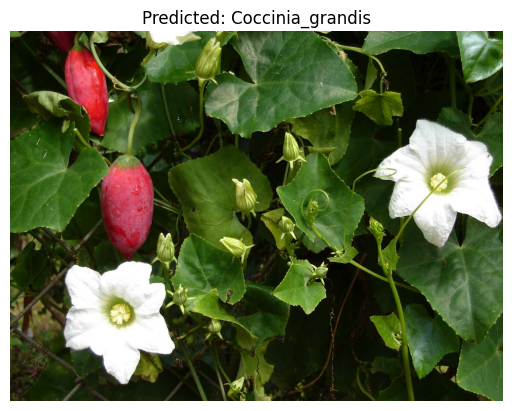

Predicted Class: 40


In [51]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model(r"D:\Ashutosh\Herbs\Output\ResNet50-\HerbClassification_BEST.h5")

# Load and preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Perform inference
def predict(img_path, class_labels=None):
    img_array = preprocess_image(img_path)
    preds = model.predict(img_array)  # Get model predictions
    predicted_class = np.argmax(preds, axis=1)[0]  # Get the highest probability class
    
    # Display the image and prediction
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[predicted_class] if class_labels else predicted_class}")
    plt.show()

    return predicted_class

# Example usage
image_path = r"C:\Users\KU_AI_M\Downloads\10.jpg"  # Change this to your image path
plant_names = [
    "Achillea Millefolium",
    "Achyranthes Aspera",
    "Acorus calamus",
    "Aegle marmelos",
    "Aerva lanata",
    "Agave americana",
    "Ageratina adenophora",
    "Allium sativum",
    "Aloe Vera",
    "Ammi majus",
    "Amomum subulatum",
    "Andrographis paniculata",
    "Annona squamosa",
    "Areca catechu",
    "Artemisia vulgaris",
    "Artocaepus lakooch",
    "Asparagus racemosus",
    "Azadirachta Indica",
    "Bacopa monnieri",
    "Bambusa vulgaris",
    "Basella alba",
    "Bergenia Ciliata",
    "Boerhavia_diffusa",
    "Bryophyllum pinnatum",
    "Butea_monosperma",
    "Calendula officinalis",
    "Calotropis Gigantea",
    "Cananga odorata",
    "Cannabis sativa",
    "Catharanthus roseus",
    "Centella asiatica",
    "Chamaecostus_cuspidatus",
    "Cheilocostus speciosus",
    "Cinnamomum verum",
    "Cissus quadrangularis",
    "Citrus_Limon",
    "Clematis montana",
    "Clerodendrum infortunatum",
    "Clerodendrum_chinense",
    "Clitoria ternatea",
    "Coccinia_grandis",
    "Coleus_amboinicus",
    "Colocasia_escullenta",
    "Curcuma_caesia",
    "Cuscuta_reflexa",
    "Cynodom_dactylon",
    "Dactylorhiza_hatagirea",
    "Datura metal linn",
    "Desmodium gangeticum",
    "Dioscorea_deltoidea",
    "Diospyros kaki",
    "Drymaria_cordata",
    "Duboisia myoporoides",
    "Eclipta Prostrata",
    "Euphorbia_hirta",
    "Fagopyrum esculentum",
    "Ficus_religiosa",
    "Gaultheria procumbens",
    "Gymnema sylvestre",
    "Helianthus annuus",
    "Hemidesmus indicus",
    "Hemigraphis colorata",
    "Hibiscus_rosa_sinensis",
    "Hyoscyamus niger",
    "Inula_cappa",
    "Iris_domestica",
    "Juglans_regia",
    "Justicia adhatoda",
    "Leucas aspera",
    "Manilkara_zapota",
    "Matricaria chamomilla",
    "Melaleuca alternifolia",
    "Mentha_spicata",
    "Morinda_citrifolia",
    "Cestrum nocturnum",
    "Ocimum_sanctum",
    "Ophiocordyceps sinensis",
    "Osyris Wightiana",
    "Oxalis Corniculata",
    "Paris pollyphyla",
    "Peperomia pellucida",
    "Persea Americana",
    "Phyllanthus Emblica",
    "Piper Longum",
    "Piper nigrum",
    "Plectranthus barbatus",
    "Pongamia Pinnata",
    "Psidium Guajava",
    "Pterocarpus Santalinus",
    "Punica Granatum",
    "Rauwolfia Serpentina",
    "Rhododendron Arboreum",
    "Rhus Javanica",
    "Ricinus Communis",
    "Rosa Rubiginosa",
    "Rose Mrytle",
    "Rubia_cordifolia",
    "Rubus Ellipticus",
    "Ruta Graveolens",
    "Sapindus mukorossi",
    "Saraca Asoca",
    "Scutellaria Discolor",
    "Solanum_xanthocarpum",
    "Tinospora cordifolia",
    "Tradescantia_spathacea",
    "Vitex negundo",
    "Withania Somnifera",
    "Xanthoparmelia scabrosa",
    "Ziziphus jujuba"
]

class_labels = plant_names  # Replace with actual class names if available
predicted_class = predict(image_path, class_labels)
print(f"Predicted Class: {predicted_class}")
